In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dimensions for the matrices
depth, height, width = 4, 4, 4

# Generating random 3D data for CT, PTV, OAR, and a target dose
ct = torch.rand(1, 1, depth, height, width)  # 1 batch, 1 channel, depth, height, width
ptv = torch.rand(1, 1, depth, height, width)
oar = torch.rand(1, 1, depth, height, width)
target_dose = torch.rand(1, 1, depth, height, width)  # This is what the model will learn to predict

# Define a simple 3D convolutional neural network
class SimpleConv3D(nn.Module):
    def __init__(self):
        super(SimpleConv3D, self).__init__()
        self.conv1 = nn.Conv3d(3, 16, kernel_size=3, padding=1)  # Input channels = 3 (CT, PTV, OAR), output channels = 16
        self.conv2 = nn.Conv3d(16, 1, kernel_size=3, padding=1)  # Output a single channel

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x

# Combine CT, PTV, OAR into a single tensor
combined_input = torch.cat([ct, ptv, oar], dim=1)  # Shape: (1, 3, depth, height, width)

# Instantiate the model
model = SimpleConv3D()

# Predict the dose
predicted_dose = model(combined_input)

# Print outputs for comparison
print("Predicted Dose:\n", predicted_dose)
print("Target Dose:\n", target_dose)


Predicted Dose:
 tensor([[[[[ 0.0408,  0.0073,  0.0256, -0.0541],
           [ 0.0240,  0.0301, -0.0187, -0.0515],
           [ 0.0036, -0.0318, -0.0024, -0.0171],
           [ 0.0726,  0.0515,  0.0484, -0.0027]],

          [[ 0.0078,  0.0243, -0.0487, -0.0297],
           [ 0.0140, -0.0956, -0.0999, -0.0717],
           [-0.0111,  0.0960,  0.0538, -0.0158],
           [ 0.0635,  0.0684,  0.0241,  0.0016]],

          [[ 0.0149, -0.0250, -0.1117, -0.0051],
           [-0.1104, -0.2354, -0.1119, -0.0873],
           [ 0.0784,  0.0021, -0.0156, -0.0799],
           [ 0.0501,  0.0071,  0.0994,  0.0408]],

          [[ 0.0471, -0.0076, -0.0258,  0.0243],
           [ 0.0071, -0.1247, -0.0519,  0.0104],
           [ 0.0164, -0.0553,  0.0485,  0.0082],
           [ 0.0120,  0.0885, -0.0074,  0.0331]]]]],
       grad_fn=<ConvolutionBackward0>)
Target Dose:
 tensor([[[[[0.0790, 0.9678, 0.0704, 0.1540],
           [0.0828, 0.5131, 0.1643, 0.7425],
           [0.1139, 0.3535, 0.0506, 0.1243],
 

Patch prediction (patch in patch out)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class Conv3DModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)  # 4 channels input
        self.conv2 = nn.Conv3d(16, 1, kernel_size=3, padding=1)  # Output a single channel for dose

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x

def extract_patch(volume, start_idx, patch_size):
    # Extract a specific patch given by start_idx and patch_size
    z, y, x = start_idx
    return volume[:, :, z:z+patch_size, y:y+patch_size, x:x+patch_size]

def update_masked_pred(masked_pred, prediction, start_idx, patch_size):
    # Update the Masked Pred volume with new predictions
    z, y, x = start_idx
    masked_pred[:, :, z:z+patch_size, y:y+patch_size, x:x+patch_size] = prediction
    return masked_pred

# Initialize data
depth, height, width = 16, 16, 16  # Larger volume for clearer demonstration
ct = torch.rand(1, 1, depth, height, width)
ptv = torch.rand(1, 1, depth, height, width)
oar = torch.rand(1, 1, depth, height, width)
masked_pred = torch.zeros(1, 1, depth, height, width)  # Start with zero masked predictions

combined_input = torch.cat([ct, ptv, oar, masked_pred], dim=1)  # 4 channels

# Model
model = Conv3DModel()

# Parameters for patch processing
patch_size = 4
stride = 4
    

updates = []


# Iterate over volume to predict patches autoregressively
for z in range(0, depth, stride):
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            patch_input = extract_patch(combined_input, (z, y, x), patch_size)
            print("Patch Input:\n", patch_input.shape)
            patch_pred = model(patch_input)
            print("Patch Predictions:\n", patch_pred.shape)
            
            masked_pred = update_masked_pred(masked_pred, patch_pred, (z, y, x), patch_size)
            combined_input = torch.cat([ct, ptv, oar, masked_pred], dim=1)  # Update input with new masked pred
            
            # Visualize after each prediction update
            # visualize_slice(masked_pred, step)
            # print("Masked Predictions:\n", masked_pred)
            
            updates.append(masked_pred.clone())
            


print("Final Masked Predictions:\n", masked_pred)


Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Input:
 torch.Size([1, 4, 4, 4, 4])
Patch Predictions:
 torch.Size([1, 1, 4, 4, 4])
Patch Inpu

In [3]:
import numpy as np

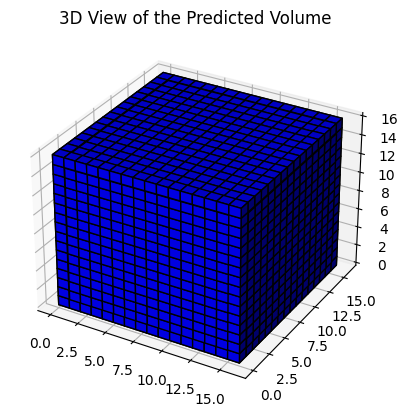

In [4]:
def visualize_volume(masked_pred):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(masked_pred[0, 0, :, :, :], facecolors='blue', edgecolor='k')
        
            
    plt.title('3D View of the Predicted Volume')
    plt.show()
    
    
visualize_volume(masked_pred)


In [5]:
from tqdm import tqdm

In [6]:
def visualize_volumes(masked_preds, num_cols):
    num_rows = len(masked_preds) // num_cols + (len(masked_preds) % num_cols > 0)
    fig = plt.figure(figsize=(3 * num_cols, 3 * num_rows))
    for i, masked_pred in enumerate(tqdm(masked_preds)):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        # Display voxels
        ax.voxels(masked_pred[0, 0, :, :, :], facecolors='blue', edgecolor='k')
        ax.set_title(f'Step {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    
steps = (depth // stride) * (height // stride) * (width // stride)  # Total number of steps based on stride
num_cols = 8  # Define number of columns in subplot grid

visualize_volumes([s.detach().numpy() for s in updates], num_cols)


  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [01:42<00:00,  1.60s/it]


KeyboardInterrupt: 

Full volume (full volume in -> full out, but select patch)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class FullVolumeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return x

def apply_patch_output(full_output, start_idx, patch_size, full_shape):
    # Zero out all parts of the output except for the patch
    z, y, x = start_idx
    new_output = torch.zeros_like(full_output)
    new_output[:, :, z:z+patch_size, y:y+patch_size, x:x+patch_size] = full_output[:, :, z:z+patch_size, y:y+patch_size, x:x+patch_size]
    return new_output

def visualize_volumes(masked_preds, num_cols):
    num_rows = len(masked_preds) // num_cols + (len(masked_preds) % num_cols > 0)
    fig = plt.figure(figsize=(3 * num_cols, 3 * num_rows))
    for i, masked_pred in enumerate(tqdm(masked_preds)):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        # Display voxels
        ax.voxels(masked_pred[0, 0, :, :, :], facecolors='blue', edgecolor='k')
        ax.set_title(f'Step {i + 1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Initialization
depth, height, width = 16, 16, 16
ct = torch.rand(1, 1, depth, height, width)
ptv = torch.rand(1, 1, depth, height, width)
oar = torch.rand(1, 1, depth, height, width)
masked_pred = torch.zeros(1, 1, depth, height, width)
combined_input = torch.cat([ct, ptv, oar, masked_pred], dim=1)

# Model
model = FullVolumeModel()

# Parameters for patch processing
patch_size = 4
stride = 4
steps = []

# Predictions and visualization
for z in range(0, depth, stride):
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            
            # print shapes
            print("Combined Input Shape:", combined_input.shape)
            model_output = model(combined_input)
            print("Model Output Shape:", model_output.shape)
            
            patch_output = apply_patch_output(model_output, (z, y, x), patch_size, (1, 1, depth, height, width))
            masked_pred += patch_output  # Update only the patch
            combined_input[:, -1, :, :, :] = masked_pred  # Update the Masked Pred channel
            steps.append(masked_pred.clone())

visualize_volumes([s.detach().numpy() for s in steps], num_cols=4)

print("Final Masked Predictions:")


Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Output Shape: torch.Size([1, 1, 16, 16, 16])
Combined Input Shape: torch.Size([1, 4, 16, 16, 16])
Model Outpu

NameError: name 'tqdm' is not defined

<Figure size 1200x4800 with 0 Axes>

full volume in -> patch out

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullVolumeToPatchModel(nn.Module):
    def __init__(self, output_patch_size):
        super().__init__()
        # Define a CNN that outputs exactly the size of a desired patch
        self.conv1 = nn.Conv3d(4, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv3d(32, 1, kernel_size=1)  # Adjust size as needed
        
        # create last conv layer based on output patch size
        out_channels = 1
        
        # additional layers to adjust to the exact output_patch_size if needed
        self.adjustment_layers = nn.Sequential(
            nn.Conv3d(1, 1, kernel_size=1, stride=1, padding=0),  # identity layer, can be customized
            nn.Upsample(size=output_patch_size, mode='trilinear', align_corners=False)  # adjust size
        )
        

    def forward(self, x):
        x = F.relu(self.conv1(x))  # shape []
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        x = self.adjustment_layers(x)
        
        return x

def run_autoregressive_predictions(model, full_input, patch_size):
    depth, height, width = full_input.shape[2:]
    full_masked_pred = torch.zeros_like(full_input[:, 0:1, :, :, :])  # Prepare a tensor to store the predictions
    
    stride_1 = patch_size[0]
    stride_2 = patch_size[1]
    stride_3 = patch_size[2]

    steps = []
    for z in range(0, depth, stride_1):
        for y in range(0, height, stride_2):
            for x in range(0, width, stride_3):
                # Make sure to use slicing that ensures output is of the correct patch size
                if z + patch_size[0] <= depth and y + patch_size[1] <= height and x + patch_size[2] <= width:
                    
                    # print("Full Input Shape:", full_input.shape)
                    # Use the full volume for context but output only the patch
                    output_patch = model(full_input)
                    
                    
                    
                    # print("Output Patch Shape:", output_patch.shape)
                    # Update the corresponding area in the full masked prediction tensor
                    new_full_masked_pred = full_masked_pred.clone()
                    new_full_masked_pred[:, :, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] = output_patch
                    full_masked_pred = new_full_masked_pred

                    # count zeros
                    # print("Number of Zeros in Masked Pred:", torch.sum(full_masked_pred == 0))
                    # Update the input for next prediction to include the new patch
                    new_full_input = full_input.clone()
                    new_full_input[:, -1:, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]] = output_patch
                    full_input = new_full_input
                    
                    
                    
                    # Update the input for next prediction to include the new patch
                    
                    
                    steps.append(full_masked_pred.clone())
                    
    return full_masked_pred, steps

# Model and inputs
model = FullVolumeToPatchModel(output_patch_size=(4, 4, 4))
input_volume = torch.rand(1, 4, 16, 16, 16)  # Full volume input including initial zeroed Masked Pred channel

# Patch size and stride for patch prediction
patch_size = (4, 4, 4)  # Size of the output patch

# Run autoregressive predictions
final_predictions, steps = run_autoregressive_predictions(model, input_volume, patch_size)
print("Final Predictions Shape:", final_predictions.shape)


Final Predictions Shape: torch.Size([1, 1, 16, 16, 16])


  0%|          | 0/64 [00:00<?, ?it/s]

 14%|█▍        | 9/64 [00:05<00:36,  1.52it/s]


KeyboardInterrupt: 

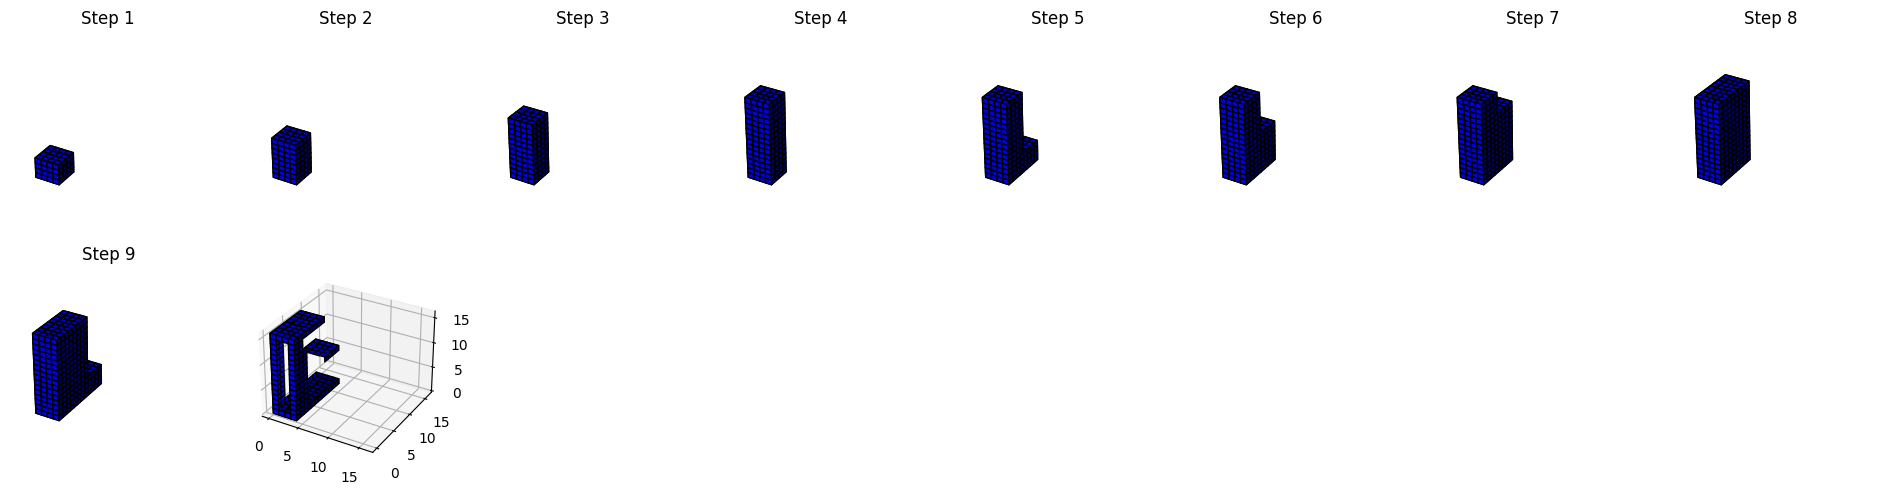

In [27]:

# visualize
visualize_volumes([s.detach().numpy() for s in steps], num_cols=8)


In [28]:
patch_size = (1, 16, 16)  # Size of the output patch


# Model and inputs
model = FullVolumeToPatchModel(output_patch_size=patch_size)
input_volume = torch.rand(1, 4, 16, 16, 16)  # Full volume input including initial zeroed Masked Pred channel

# Patch size and stride for patch prediction
stride = 1  # Stride for patch prediction

# Run autoregressive predictions
final_predictions, steps = run_autoregressive_predictions(model, input_volume, patch_size)
print("Final Predictions Shape:", final_predictions.shape)


Final Predictions Shape: torch.Size([1, 1, 16, 16, 16])


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:29<00:00,  1.82s/it]


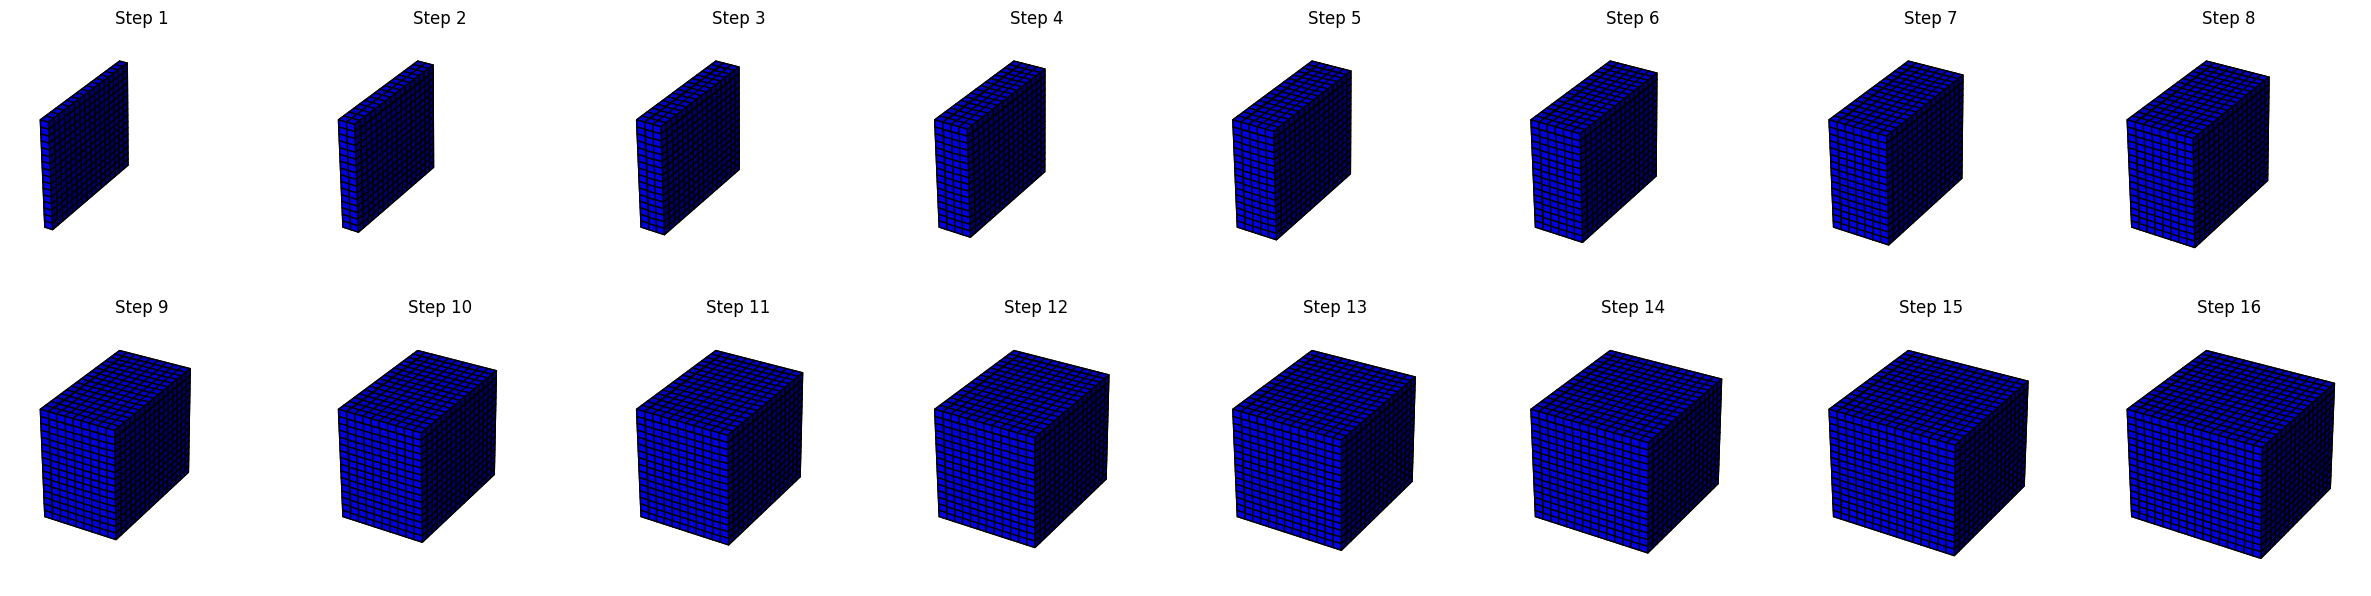

In [29]:
# visualize
visualize_volumes([s.detach().numpy() for s in steps], num_cols=8)

In [30]:
# let's make a train pipeline to train the model autoregressively

def train_model(model, optimizer, criterion, input_data, patch_size, num_epochs):
    
    for i, batch in enumerate(input_data):
        data = batch.unsqueeze(0) # shape: (1, 5, depth, height, width) already has the masked pred channel and target
        full_input = data[:, :-1, :, :, :] # Exclude the target dose channel
        target_dose = data[:, -1:, :, :, :]
        
        for epoch in range(num_epochs):
            full_masked_pred, steps = run_autoregressive_predictions(model, full_input, patch_size)
            loss = criterion(full_masked_pred, target_dose)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
            
    return model        
        
        
        
    

patch_size = (1, 16, 16)  # Size of the output patch

model = FullVolumeToPatchModel(output_patch_size=patch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 10
# initialize 20 images
input_volumes = torch.rand(20, 5, 16, 16, 16)  # 20 random input volumes with mask and target dose

train_model = train_model(model, optimizer, criterion, input_volumes, patch_size, num_epochs)

Epoch 1, Loss: 0.7159479856491089
Epoch 2, Loss: 0.7033989429473877
Epoch 3, Loss: 0.6900469064712524
Epoch 4, Loss: 0.6744170188903809
Epoch 5, Loss: 0.6558235883712769
Epoch 6, Loss: 0.6340898871421814
Epoch 7, Loss: 0.6088635921478271
Epoch 8, Loss: 0.5797057151794434
Epoch 9, Loss: 0.5462092757225037
Epoch 10, Loss: 0.5082099437713623
Epoch 1, Loss: 0.45083731412887573
Epoch 2, Loss: 0.40465405583381653
Epoch 3, Loss: 0.35474398732185364
Epoch 4, Loss: 0.30202561616897583
Epoch 5, Loss: 0.24844181537628174
Epoch 6, Loss: 0.19729335606098175
Epoch 7, Loss: 0.15409907698631287
Epoch 8, Loss: 0.1272643506526947
Epoch 9, Loss: 0.12753888964653015
Epoch 10, Loss: 0.15559352934360504
Epoch 1, Loss: 0.17189152538776398
Epoch 2, Loss: 0.18148180842399597
Epoch 3, Loss: 0.17285826802253723
Epoch 4, Loss: 0.1546921730041504
Epoch 5, Loss: 0.1359713226556778
Epoch 6, Loss: 0.12194151431322098
Epoch 7, Loss: 0.11409880965948105
Epoch 8, Loss: 0.11158614605665207
Epoch 9, Loss: 0.11256377398967